# Retrieve Data

In [ ]:
# Import the necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil

In [ ]:
root = "/content/drive/MyDrive/DTSA 5511 - Deep Learning/esco_predict"
dir = os.path.join(root, "raw_data")
file = os.path.join(dir, "facility_int_data.csv")
print(file)


raw_data = pd.read_csv(file)

/content/drive/MyDrive/DTSA 5509 - Intro to ML/esco_predict/raw_data/facility_int_data.csv


Now let's clean the data by removing some unnecessary attributes


In [ ]:
print(raw_data.head())

   Service Agreement Start Date Time   End Date Time   Usage Usage Unit  \
0          241326005  2/13/2017 0:00  2/13/2017 0:15  403.92        KWH   
1          241326005  2/13/2017 0:15  2/13/2017 0:30  401.76        KWH   
2          241326005  2/13/2017 0:30  2/13/2017 0:45  408.24        KWH   
3          241326005  2/13/2017 0:45  2/13/2017 1:00  410.76        KWH   
4          241326005  2/13/2017 1:00  2/13/2017 1:15  401.04        KWH   

   Avg. Temperature Temperature Unit  Peak Demand Demand Unit Baseline year  
0              47.0       FAHRENHEIT      1615.68          KW           NaN  
1              47.0       FAHRENHEIT      1607.04          KW          XOXO  
2              47.0       FAHRENHEIT      1632.96          KW          XOXO  
3              47.0       FAHRENHEIT      1643.04          KW           NaN  
4              45.0       FAHRENHEIT      1604.16          KW           NaN  


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100992 entries, 0 to 100991
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Service Agreement  100992 non-null  int64  
 1   Start Date Time    100992 non-null  object 
 2   End Date Time      100992 non-null  object 
 3   Usage              99524 non-null   float64
 4   Usage Unit         99524 non-null   object 
 5   Avg. Temperature   100984 non-null  float64
 6   Temperature Unit   100992 non-null  object 
 7   Peak Demand        99524 non-null   float64
 8   Demand Unit        99524 non-null   object 
 9   Baseline year      35042 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 7.7+ MB


In [ ]:
raw_data = raw_data[['Start Date Time','End Date Time','Avg. Temperature','Usage']]
raw_data.columns = ['start_time','end_time','s-temp','usage_kWh']
raw_data.head()

,start_time,end_time,s-temp,usage_kWh
0,2/13/2017 0:00,2/13/2017 0:15,47.0,403.92
1,2/13/2017 0:15,2/13/2017 0:30,47.0,401.76
2,2/13/2017 0:30,2/13/2017 0:45,47.0,408.24
3,2/13/2017 0:45,2/13/2017 1:00,47.0,410.76
4,2/13/2017 1:00,2/13/2017 1:15,45.0,401.04


In [ ]:
df = raw_data.copy()
df['start_time'] = pd.to_datetime(df['start_time'])

# Set start_time as the index
df.set_index('start_time', inplace=True)
# print(df.head())
# Resample to 1-hour intervals and sum the usage_kWh, average temperature
hourly_data = df[['usage_kWh']].resample('h').sum().reset_index()  # Sum for hourly usage
hourly_temp = df[['s-temp']].resample('h').mean().reset_index()  # Mean temperature for each hour
hourly_data = hourly_data.merge(hourly_temp, on = 'start_time')
# Display the resulting DataFrame
hourly_data.head(10)

,start_time,usage_kWh,s-temp
0,2017-02-13 00:00:00,1624.68,47.0
1,2017-02-13 01:00:00,1612.08,45.0
2,2017-02-13 02:00:00,1605.60,44.0
3,2017-02-13 03:00:00,1624.32,43.0
4,2017-02-13 04:00:00,1797.12,44.0
5,2017-02-13 05:00:00,1918.80,42.0
6,2017-02-13 06:00:00,1923.84,43.0
7,2017-02-13 07:00:00,1877.40,44.0
8,2017-02-13 08:00:00,1533.60,45.0
9,2017-02-13 09:00:00,1003.32,47.0


In [ ]:
energy_data = hourly_data.copy()

# Feature Engineering

In [ ]:
# raw_data["datetime"] = pd.to_datetime(merged_df['DATE'] + ' ' + merged_df['START TIME'])
# # merged_df['usage_kWh'] = merged_df['USAGE (kWh)']
# energy_data = merged_df[['datetime', 'usage_kWh']]
# energy_data.drop( columns = ['end_time'],inplace = True)
energy_data.columns = ['datetime','usage_kWh','s-temp']

In [ ]:
energy_data.loc[:,'hour'] = energy_data['datetime'].dt.hour+1
energy_data.loc[:,'weekday'] = energy_data['datetime'].dt.weekday
energy_data.loc[:,'month'] = energy_data['datetime'].dt.month

energy_data.head()

,datetime,usage_kWh,s-temp,hour,weekday,month
0,2017-02-13 00:00:00,1624.68,47.0,1,0,2
1,2017-02-13 01:00:00,1612.08,45.0,2,0,2
2,2017-02-13 02:00:00,1605.60,44.0,3,0,2
3,2017-02-13 03:00:00,1624.32,43.0,4,0,2
4,2017-02-13 04:00:00,1797.12,44.0,5,0,2


In [ ]:
def time_feature_engr(energy_data):
  #Cyclic encoding for periodic features
  #This maps the hour, weekday, and month features so that the distance between values is consistent
  energy_data.loc[:,"weekday_sin"] = np.sin(2 * np.pi * energy_data["weekday"] / (7*24))
  energy_data.loc[:,"weekday_cos"] = np.cos(2 * np.pi * energy_data["weekday"] / (7*24))
  energy_data.loc[:,"hour_sin"] = np.sin(2 * np.pi * energy_data["hour"] / 24)
  energy_data.loc[:,"hour_cos"] = np.cos(2 * np.pi * energy_data["hour"] / 24)
  energy_data.loc[:,"month_sin"] = np.sin(2 * np.pi * energy_data["month"] / (30.4*24))
  energy_data.loc[:,"month_cos"] = np.cos(2 * np.pi * energy_data["month"] / (30.4*24))

  #Include a weekday-hour interaction to model time-based patterns
  #This could caputre peak usage, say on Friday nights or Saturday mornings
  energy_data["weekday_hour"] = energy_data.weekday.astype(str) + '-' + energy_data.hour.astype(str)

  #weekday_hour will be inluded as an object variable so we need to transform it using
  #one-hot encoding or lebel encoding. I'll use label encoding becasue it's less
  #computationally expensive. Now,  each weekday-hour combination will have its own label
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  energy_data["weekday_hour"] = le.fit_transform(energy_data["weekday_hour"])
  return energy_data

energy_data = time_feature_engr(energy_data)
energy_data.head()

,datetime,usage_kWh,s-temp,hour,weekday,month,weekday_sin,weekday_cos,hour_sin,hour_cos,month_sin,month_cos,weekday_hour
0,2017-02-13 00:00:00,1624.68,47.0,1,0,2,0.0,1.0,0.258819,0.965926,0.017223,0.999852,0
1,2017-02-13 01:00:00,1612.08,45.0,2,0,2,0.0,1.0,0.500000,0.866025,0.017223,0.999852,11
2,2017-02-13 02:00:00,1605.60,44.0,3,0,2,0.0,1.0,0.707107,0.707107,0.017223,0.999852,17
3,2017-02-13 03:00:00,1624.32,43.0,4,0,2,0.0,1.0,0.866025,0.500000,0.017223,0.999852,18
4,2017-02-13 04:00:00,1797.12,44.0,5,0,2,0.0,1.0,0.965926,0.258819,0.017223,0.999852,19


In [ ]:
# Find the minimum and maximum values so the corresponding weather data can be retreived
min_datetime = energy_data['datetime'].min()
max_datetime = energy_data['datetime'].max()

# Print the results
print("Minimum datetime:", min_datetime)
print("Maximum datetime:", max_datetime)

#Sort the data to make sure the temporal integrity is maintained in the data
energy_data = energy_data.sort_values(by = 'datetime')
energy_data.reset_index(drop = True, inplace = True)

Minimum datetime: 2017-02-13 00:00:00
Maximum datetime: 2019-12-31 23:00:00


In [ ]:
# Read in measured weather data
root = "/content/drive/MyDrive/DTSA 5511 - Deep Learning/esco_predict"
dir = os.path.join(root, "raw_data")
file = os.path.join(dir, "weather.csv")
print(file)
weather_data = pd.read_csv(file)
weather_data.info()

# dataset.dropna(inplace = True)
# dataset.drop(columns = 's-temp',inplace = True)

/content/drive/MyDrive/DTSA 5509 - Intro to ML/esco_predict/raw_data/weather.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25296 entries, 0 to 25295
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              25296 non-null  object 
 1   datetime          25296 non-null  object 
 2   temp              25296 non-null  float64
 3   feelslike         25296 non-null  float64
 4   dew               25296 non-null  float64
 5   humidity          25296 non-null  float64
 6   precip            25296 non-null  float64
 7   precipprob        25296 non-null  int64  
 8   preciptype        1165 non-null   object 
 9   snow              25264 non-null  float64
 10  snowdepth         25264 non-null  float64
 11  windgust          25262 non-null  float64
 12  windspeed         25296 non-null  float64
 13  winddir           25296 non-null  float64
 14  sealevelpressure  25296 non-null  float64
 15  cloudc

In [ ]:
# Clean the weather data t
weather_data_clean = weather_data[['datetime','temp','cloudcover','solarradiation','windspeed']]
# weather_data_clean.columns = weather_data[['datetime','h-temp','cloudcover','solarradiation']]
# weather_data_clean = weather_data.drop(columns = ['source'])
weather_data_clean['datetime'] = pd.to_datetime(weather_data_clean['datetime'])
weather_data_clean.set_index('datetime', inplace=True)

weather_data_clean.head()

/tmp/ipython-input-15-2213123962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_clean['datetime'] = pd.to_datetime(weather_data_clean['datetime'])


,temp,cloudcover,solarradiation,windspeed
datetime,,,,
2017-02-12 00:00:00,42.3,0.0,0.0,1.4
2017-02-12 01:00:00,41.2,0.0,0.0,0.1
2017-02-12 02:00:00,40.5,0.0,0.0,0.2
2017-02-12 03:00:00,39.0,0.0,0.0,1.4
2017-02-12 04:00:00,38.7,0.0,0.0,0.2


In [ ]:
# Merge weather data with the dataset
dataset = energy_data.merge(weather_data_clean, on = 'datetime', how = 'left')
dataset.drop(columns = ['temp'],inplace = True)
dataset = dataset.rename(columns={'s-temp': 'temp'})
col = dataset.pop('usage_kWh')
dataset.insert(dataset.shape[1], 'usage_kWh', col)
print(dataset.head())

             datetime  temp  hour  weekday  month  weekday_sin  weekday_cos  \
0 2017-02-13 00:00:00  47.0     1        0      2          0.0          1.0   
1 2017-02-13 01:00:00  45.0     2        0      2          0.0          1.0   
2 2017-02-13 02:00:00  44.0     3        0      2          0.0          1.0   
3 2017-02-13 03:00:00  43.0     4        0      2          0.0          1.0   
4 2017-02-13 04:00:00  44.0     5        0      2          0.0          1.0   

   hour_sin  hour_cos  month_sin  month_cos  weekday_hour  cloudcover  \
0  0.258819  0.965926   0.017223   0.999852             0         0.0   
1  0.500000  0.866025   0.017223   0.999852            11         0.0   
2  0.707107  0.707107   0.017223   0.999852            17         0.0   
3  0.866025  0.500000   0.017223   0.999852            18         0.0   
4  0.965926  0.258819   0.017223   0.999852            19         0.0   

   solarradiation  windspeed  usage_kWh  
0             0.0        5.1    1624.68  
1 

In [ ]:
#Apply a log transformation to target variable to help model deal with variance in the data
#We will have to transform it back after predictions are made

dataset.info()

dataset.loc[:, "usage_kWh"] = np.log1p(dataset["usage_kWh"])

print(dataset['weekday_hour'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25251 entries, 0 to 25250
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        25251 non-null  datetime64[ns]
 1   temp            25249 non-null  float64       
 2   hour            25251 non-null  int32         
 3   weekday         25251 non-null  int32         
 4   month           25251 non-null  int32         
 5   weekday_sin     25251 non-null  float64       
 6   weekday_cos     25251 non-null  float64       
 7   hour_sin        25251 non-null  float64       
 8   hour_cos        25251 non-null  float64       
 9   month_sin       25251 non-null  float64       
 10  month_cos       25251 non-null  float64       
 11  weekday_hour    25251 non-null  int64         
 12  cloudcover      25248 non-null  float64       
 13  solarradiation  25248 non-null  float64       
 14  windspeed       25248 non-null  float64       
 15  us

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#This function adds a lag feature based on past values only. This would make sense for
# models used for both forecasting and estimating past values. Using a centered lag could be suitable
#for estimating past values only because future values are not available in forecasting scenarios.

def add_lag_feature(df, window, shift = 1, stat = ['mean','max','min','std'], lag_cols = ["temp","solarradtion","cloudcover"]):

  if stat == 'mean':
    for col in lag_cols:
        df[f"{col}_mean_lag{window}_sh{shift}"] = (df[col]
            .shift(shift)  # Shift by 1 to exclude the current value
            .rolling(window=window, min_periods= window)  # Rolling over past values
            .mean() # Take the mean of the previous three values
        )
  elif stat == 'max':
    for col in lag_cols:
        df[f"{col}_max_lag{window}_sh{shift}"] = (df[col]
        .shift(shift)
        .rolling(window=window, min_periods= window)
        .quantile(0.95) # Take the 95th percentile of the previous three values
        )
  elif stat == 'min':
    for col in lag_cols:
        df[f"{col}_min_lag{window}_sh{shift}"] = (df[col]
        .shift(shift)
        .rolling(window=window, min_periods= window)
        .quantile(0.05) # Take the 5th percentile of the previous three values
        )
  elif stat == 'std':
    for col in lag_cols:
        df[f"{col}_std_lag{window}_sh{shift}"] = (df[col]
        .shift(shift)
        .rolling(window=window, min_periods= window)
        .std() # Take the standard devition of the previous three values
        )


add_lag_feature(dataset, window = 3, stat = 'mean', lag_cols = ["temp"] )
add_lag_feature(dataset, window = 12, stat = 'mean', lag_cols = ["temp"] )
add_lag_feature(dataset, window = 24, stat = 'mean', lag_cols = ["temp"] )
add_lag_feature(dataset, window = 3, stat = 'max', lag_cols = ["temp"] )
add_lag_feature(dataset, window = 3, stat = 'min', lag_cols = ["temp"] )
add_lag_feature(dataset, window = 3, stat = 'std', lag_cols = ["temp"] )
add_lag_feature(dataset, window = 3, stat = 'mean', lag_cols = ["solarradiation"] )
add_lag_feature(dataset, window = 3, stat = 'mean', lag_cols = ["windspeed"] )

# add_lag_feature(dataset, window = 3, stat = 'std', lag_cols = ["solarradiation"] )
add_lag_feature(dataset, window = 24, stat = 'mean', lag_cols = ["solarradiation"] )
add_lag_feature(dataset, window = 3, stat = 'mean', lag_cols = ["cloudcover"] )

#Previous day 3-hour mean temp centered around the hour
add_lag_feature(dataset, window = 3, shift = 24, stat = 'mean', lag_cols = ["temp"] )

#centered lag
add_lag_feature(dataset, window = 5, shift = -2, stat = 'mean', lag_cols = ["solarradiation"] )

#Drop NaN value rows resulting from lag features
dataset.dropna(inplace = True)

col = dataset.pop('usage_kWh')
dataset.insert(dataset.shape[1], 'usage_kWh', col)

In [ ]:
def add_gradient_feature(df, lag=1, gradient_cols=None):
    """
    Adds a gradient (rate of change) feature for specified columns.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - lag (int): The lag period to calculate the gradient.
    - gradient_cols (list): List of column names for which to calculate the gradient.

    Returns:
    - None: Modifies the dataframe in place by adding gradient columns.
    """
    if gradient_cols is None:
        gradient_cols = []

    for col in gradient_cols:
        df[f"{col}_gradient_lag{lag}"] = (df[col] - df[col].shift(lag)) / lag

# Add gradient features
add_gradient_feature(dataset, lag=1, gradient_cols=["temp", "solarradiation"])
# add_gradient_feature(dataset, lag=3, gradient_cols=["temp", "solarradiation"])
# add_gradient_feature(dataset, lag=5, gradient_cols=["temp", "solarradiation"])

# Drop NaN values resulting from the lag
dataset.dropna(inplace=True)

# Check the new columns
print(dataset.head())


              datetime  temp  hour  weekday  month  weekday_sin  weekday_cos  \
27 2017-02-14 03:00:00  49.0     4        1      2     0.037391     0.999301   
28 2017-02-14 04:00:00  48.0     5        1      2     0.037391     0.999301   
29 2017-02-14 05:00:00  48.0     6        1      2     0.037391     0.999301   
30 2017-02-14 06:00:00  46.0     7        1      2     0.037391     0.999301   
31 2017-02-14 07:00:00  45.0     8        1      2     0.037391     0.999301   

    hour_sin      hour_cos  month_sin  ...  temp_std_lag3_sh1  \
27  0.866025  5.000000e-01   0.017223  ...           0.577350   
28  0.965926  2.588190e-01   0.017223  ...           1.000000   
29  1.000000  6.123234e-17   0.017223  ...           1.000000   
30  0.965926 -2.588190e-01   0.017223  ...           0.577350   
31  0.866025 -5.000000e-01   0.017223  ...           1.154701   

    solarradiation_mean_lag3_sh1  windspeed_mean_lag3_sh1  \
27                           0.0                 0.800000   
28    

# EDA
Let's do some visualizations to get an idea of what the data looks like.

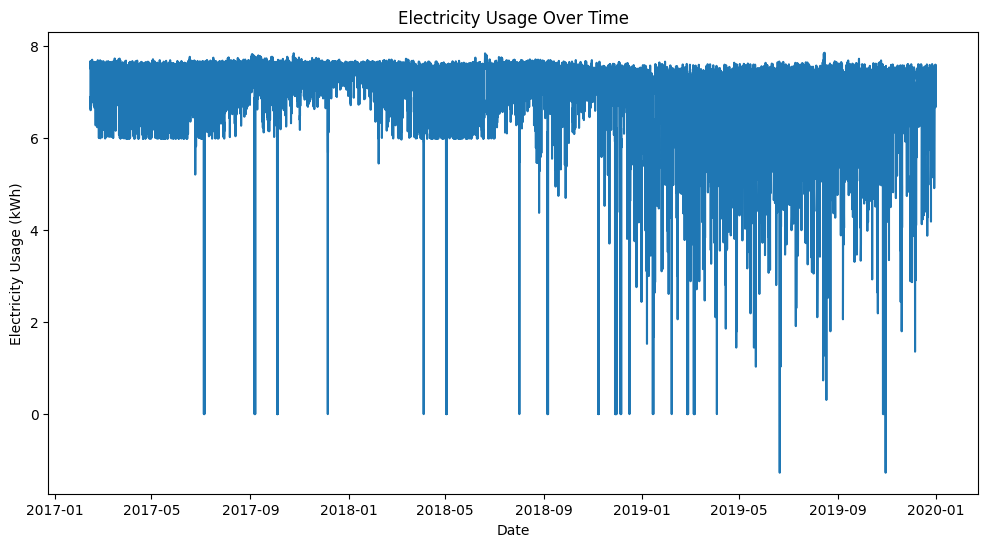

In [ ]:
#Line plot for electricity usage and temperature
plt.figure(figsize = (12,6))
plt.plot(dataset['datetime'], dataset['usage_kWh'])
plt.xlabel('Date')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage Over Time')
plt.show()

In [ ]:
# is_missing = dataset['usage_kWh'].isna()

# # Find the start and length of each missing chunk
# missing_chunks = is_missing.astype(int).groupby(is_missing.ne(is_missing.shift()).cumsum()).cumsum() * is_missing

# # Calculate the length of each missing chunk
# chunk_lengths = missing_chunks[missing_chunks > 0].value_counts()

# # Summarize the lengths and quantities of each chunk size
# length_counts = chunk_lengths.value_counts().sort_index()

# # Output the result
# print("Length of missing chunks and their quantities:")
# print(length_counts)

zeros = dataset['usage_kWh'].eq(0).sum()
print(zeros/len(dataset))

0.007235402995120309



Focus the plot on a subset of data to generate more a interpretable and visualizations.

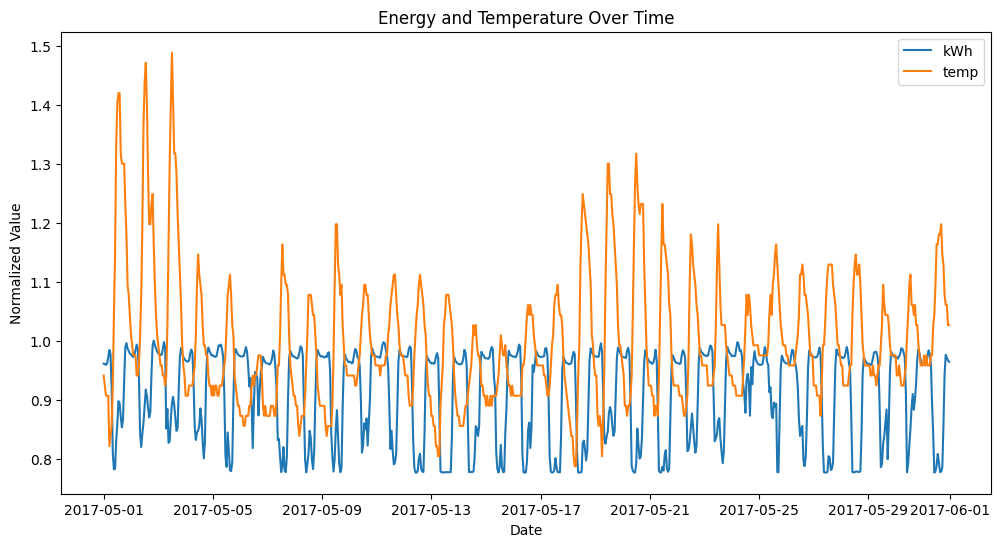

In [ ]:
# Filter the dataset for values from May of 'year'
year = 2017
# Let's also overlay temperature while normalizing the data
dataset_may_2024 = dataset[(dataset['datetime'].dt.year == year) & (dataset['month'] == 5)]

plt.figure(figsize = (12,6))
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['usage_kWh']/dataset_may_2024['usage_kWh'].max(), label = 'kWh')
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['temp']/dataset_may_2024['temp'].mean(), label = 'temp')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Energy and Temperature Over Time')
plt.legend()
plt.show()

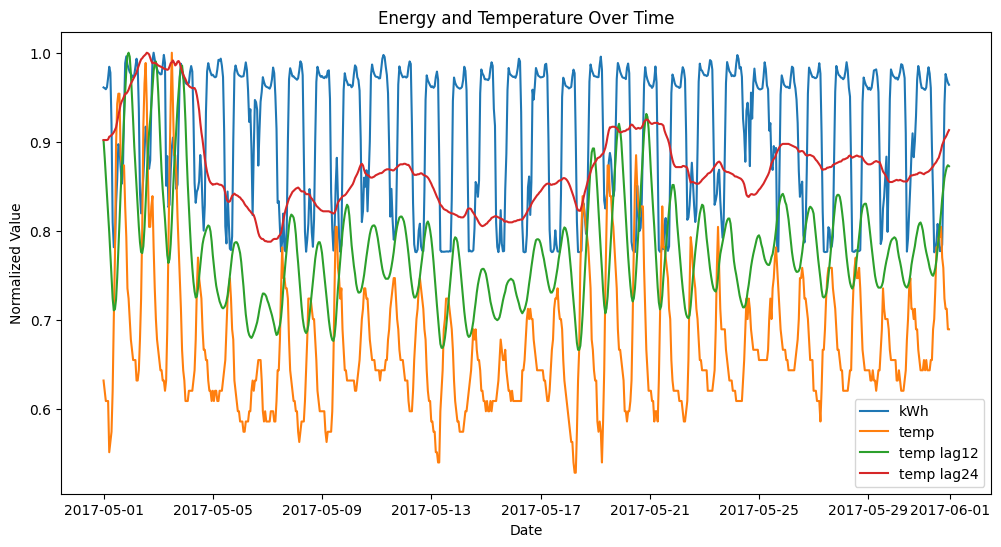

In [ ]:
# Filter the dataset for values from May 2024
# Let's look at the temp lag features
dataset_may_2024 = dataset[(dataset['datetime'].dt.year == year) & (dataset['month'] == 5)]

plt.figure(figsize = (12,6))
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['usage_kWh']/dataset_may_2024['usage_kWh'].max(), label = 'kWh')
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['temp']/dataset_may_2024['temp'].max(), label = 'temp')
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['temp_mean_lag12_sh1']/dataset_may_2024['temp_mean_lag12_sh1'].max(), label = 'temp lag12')
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['temp_mean_lag24_sh1']/dataset_may_2024['temp_mean_lag24_sh1'].max(), label = 'temp lag24')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Energy and Temperature Over Time')
plt.legend()
plt.show()

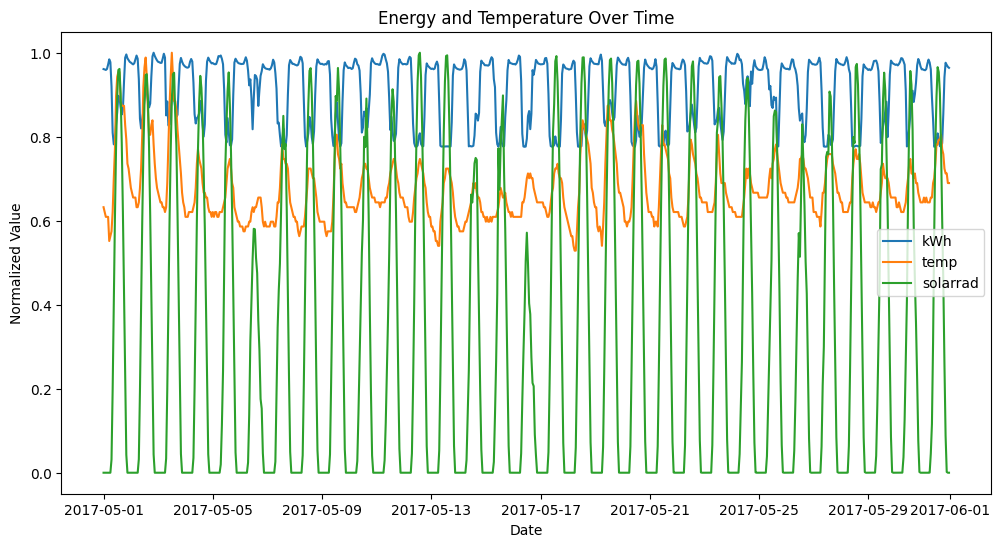

In [ ]:
# Filter the dataset for values from May 2024
# Let's look at the 3hr-lag features
dataset_may_2024 = dataset[(dataset['datetime'].dt.year == year) & (dataset['month'] == 5)]

plt.figure(figsize = (12,6))
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['usage_kWh']/dataset_may_2024['usage_kWh'].max(), label = 'kWh')
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['temp']/dataset_may_2024['temp'].max(), label = 'temp')
plt.plot(dataset_may_2024['datetime'], dataset_may_2024['solarradiation']/dataset_may_2024['solarradiation'].max(), label = 'solarrad')
# plt.plot(dataset_may_2024['datetime'], dataset_may_2024['temp_max_lag3_sh1']/dataset_may_2024['temp_max_lag3_sh1'].max(), label = 'temp max lag3')
# plt.plot(dataset_may_2024['datetime'], dataset_may_2024['temp_min_lag3_sh1']/dataset_may_2024['temp_min_lag3_sh1'].max(), label = 'temp min lag3')

plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Energy and Temperature Over Time')
plt.legend()
plt.show()

Let's take a closer look at the beginning of May to see if we can visualize why the temperature dipped.

In [ ]:
# Filter the dataset for values from May 2024

dataset_may_dates = dataset[(dataset['datetime'].dt.year == year) & (dataset['month'] == 5) & (dataset['datetime'].dt.day <= 6)]

Index(['datetime', 'temp', 'hour', 'weekday', 'month', 'weekday_sin',
       'weekday_cos', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'weekday_hour', 'cloudcover', 'solarradiation', 'windspeed',
       'temp_mean_lag3_sh1', 'temp_mean_lag12_sh1', 'temp_mean_lag24_sh1',
       'temp_max_lag3_sh1', 'temp_min_lag3_sh1', 'temp_std_lag3_sh1',
       'solarradiation_mean_lag3_sh1', 'windspeed_mean_lag3_sh1',
       'solarradiation_mean_lag24_sh1', 'cloudcover_mean_lag3_sh1',
       'temp_mean_lag3_sh24', 'solarradiation_mean_lag5_sh-2', 'usage_kWh',
       'temp_gradient_lag1', 'solarradiation_gradient_lag1'],
      dtype='object')


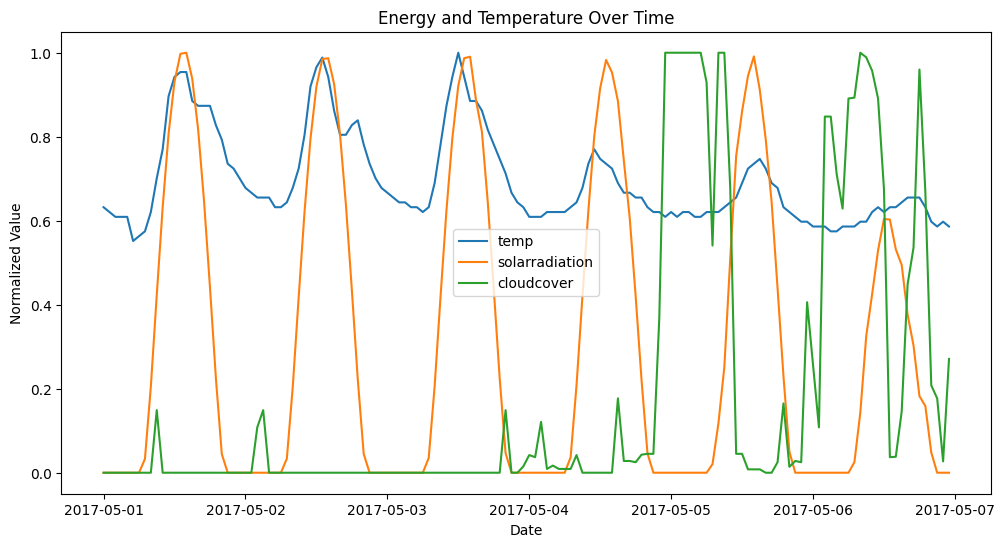

In [ ]:
print(dataset.columns)
plt.figure(figsize = (12,6))
# plt.plot(dataset_may_dates['datetime'], dataset_may_dates['usage_kWh']/dataset_may_dates['usage_kWh'].max(), label = 'kWh')
plt.plot(dataset_may_dates['datetime'], dataset_may_dates['temp']/dataset_may_dates['temp'].max(), label = 'temp')
plt.plot(dataset_may_dates['datetime'], dataset_may_dates['solarradiation']/dataset_may_dates['solarradiation'].max(), label = 'solarradiation')
plt.plot(dataset_may_dates['datetime'], dataset_may_dates['cloudcover']/dataset_may_dates['cloudcover'].max(), label = 'cloudcover')

plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Energy and Temperature Over Time')
plt.legend()
plt.show()

#Initial Feature Selection
Let's drop some features because they are either highly correlated with each other or redundant. Use domain knowledge to drop these features because including them can introduce multicollinearity, inflate the model's complexity, and dilute the predictive power of truly informative features, potentially leading to overfitting.

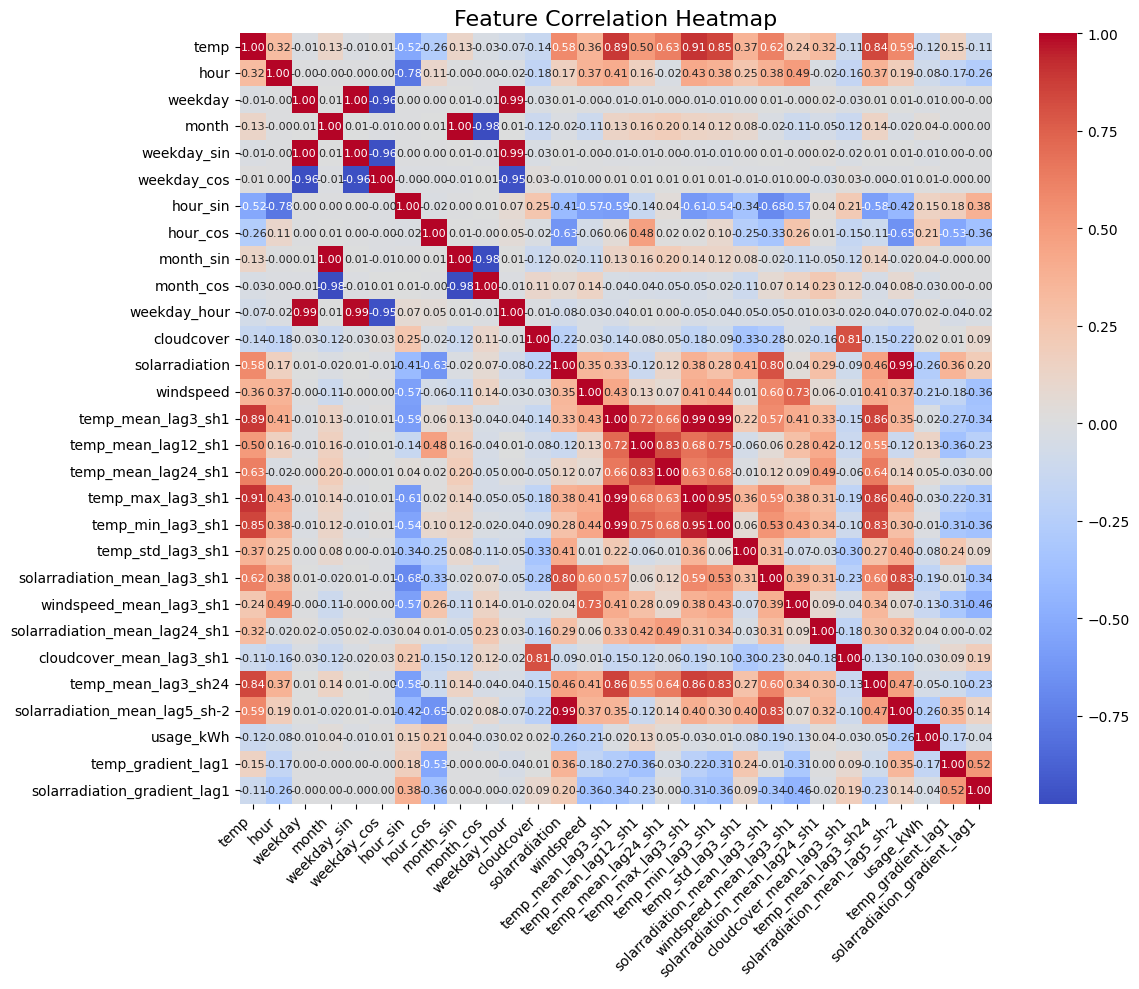

In [ ]:
correlation_matrix = dataset.drop(columns=['datetime']).corr()

# Identify highly correlated features
threshold = 0.8  # You can adjust this threshold
high_correlation_pairs = []

# Iterate over the upper triangle of the matrix (to avoid duplicates)
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            high_correlation_pairs.append((feature_1, feature_2, correlation_matrix.iloc[i, j]))

plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, annot_kws={"size": 8})
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Drop Features

In [ ]:
#Drop the 'datetime' feature becasue it's an object type and we already respresent this value with other features
dataset.drop(columns = ['datetime'], inplace = True)

#Drop month feature - I don't believe any certain month to be associated with higher energy use
# dataset.drop(columns = ['month'], inplace = True)

#Drop solar radiation 24-hr lag becasue it is highly correlated with all of the temperature features
#Keep solar radiation 3-hr lag because it seems to have less overlap with temp variables, has a higher
#correlation to the target, and makes sense that the 3-hr lag would contribute more to energy use
dataset.drop(columns = ['solarradiation_mean_lag24_sh1'], inplace = True)

#Drop 3hr temp max, min, standard deviation lags becasue theu basically overlap the mean lag feature.
#I was hoping to caputre some variability here but the temp data looks to be very stable
# dataset.drop(columns = ['temp_max_lag3_sh1','temp_min_lag3_sh1','temp_std_lag3_sh1'], inplace = True)

#Drop current solar radiation and cloud cover features becasue these likely don't
#affect the target variable within an hour. Also, these variables could not be included
#for forecasting purposes.
# dataset.drop(columns = ['temp','solarradiation','cloudcover'], inplace = True)

### Split the Dataset

In [ ]:
#Determine how to split the dataset into training and test sets.
#There's a little more than 3 years worth of data. Let's use the first 2 years to train
#and the last year as the test set

total_years = len(dataset)/(24*365)
test_years = 1
train_years = total_years - test_years

train_observations = int(train_years * (24 * 365))
test_observations = int(test_years * (24 * 365))

train_perc = train_observations/len(dataset)
test_perc = test_observations/len(dataset)

#Make sure I got the calculation right
print(train_perc)
print(test_perc)
print(train_perc + test_perc)


train_df = dataset.iloc[:train_observations,:]
test_df = dataset.iloc[train_observations:,:]

0.6314571765101801
0.3685007571933367
0.9999579337035167


In [ ]:
#Save the training dataset at a pickle file
dir = os.path.join(root, "processed_data")
file = os.path.join(dir, "processed_training_set.pkl")
train_df.to_pickle(file)

In [ ]:
#Save the testing dataset at a pickle file
dir = os.path.join(root, "processed_data")
file = os.path.join(dir, "processed_test_set.pkl")
test_df.to_pickle(file)

In [ ]:
test_df.head()

,temp,hour,weekday,month,weekday_sin,weekday_cos,hour_sin,hour_cos,month_sin,month_cos,...,temp_min_lag3_sh1,temp_std_lag3_sh1,solarradiation_mean_lag3_sh1,windspeed_mean_lag3_sh1,cloudcover_mean_lag3_sh1,temp_mean_lag3_sh24,solarradiation_mean_lag5_sh-2,usage_kWh,temp_gradient_lag1,solarradiation_gradient_lag1
15146,46.0,1,1,11,0.037391,0.999301,0.258819,0.965926,0.094588,0.995516,...,48.3,3.511885,2.333333,0.066667,0.0,55.666667,2.8,7.384561,-2.0,0.0
15147,47.0,2,1,11,0.037391,0.999301,0.500000,0.866025,0.094588,0.995516,...,46.2,2.516611,2.666667,0.066667,0.0,54.666667,3.0,7.361274,1.0,0.0
15148,47.0,3,1,11,0.037391,0.999301,0.707107,0.707107,0.094588,0.995516,...,46.1,1.000000,3.000000,0.066667,0.0,54.000000,3.0,7.375807,0.0,0.0
15149,46.0,4,1,11,0.037391,0.999301,0.866025,0.500000,0.094588,0.995516,...,46.1,0.577350,3.000000,0.133333,0.0,54.000000,3.0,7.370835,-1.0,0.0
15150,43.0,5,1,11,0.037391,0.999301,0.965926,0.258819,0.094588,0.995516,...,46.1,0.577350,3.000000,0.100000,0.0,53.666667,4.0,7.442727,-3.0,0.0
